In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from catboost import CatBoost
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
from catboost import Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

Зафиксирую random seed

In [2]:
rs = 1385 

Собрал воедино график работы по сменам, отчеты выручки по датам, скачал сводку погоды на этот промежуток времени

In [3]:
df = pd.read_csv('C:\Games\Learnin\Выручка-бариста.csv', header=1)

In [4]:
df = df.fillna('0')

_________________________________________________________________

<AxesSubplot:>

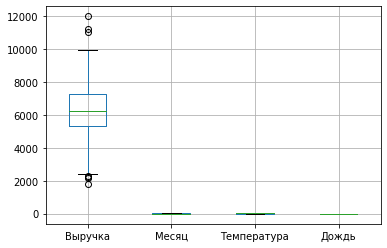

In [5]:
df.boxplot()

In [311]:
df.shape

(454, 7)

Z-score и 2 сигма

*

In [5]:
z = stats.zscore(df['Выручка'])

In [6]:
bd = list(np.where(abs(z) >2)[0])

In [7]:
dfz = df.drop(index=bd)

*

In [9]:
dfz.describe()

,Выручка,Месяц,Температура,Дождь
count,432.000000,432.000000,432.000000,432.000000
mean,6277.430556,6.444444,10.898380,0.342593
std,1346.993256,3.104770,10.821842,0.475127
min,3150.000000,1.000000,-17.400000,0.000000
25%,5398.750000,4.000000,2.000000,0.000000
50%,6250.000000,6.000000,11.150000,0.000000
75%,7290.000000,9.000000,19.300000,1.000000
max,9360.000000,12.000000,33.600000,1.000000


<AxesSubplot:>

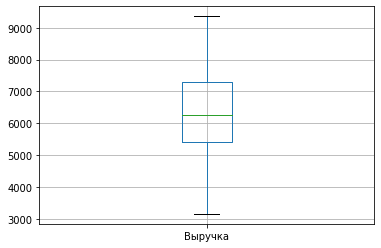

In [10]:
dfz.boxplot(column='Выручка')

Квартили и 3 сигма

In [11]:
Q1 =  df['Выручка'].quantile(0.25)
Q3 = df['Выручка'].quantile(0.75)
IQR = Q3 - Q1

<AxesSubplot:>

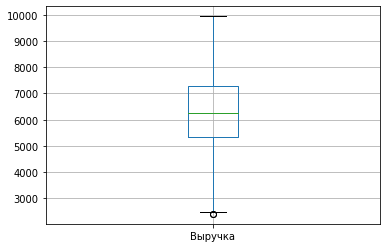

In [12]:
dfq = df[(df['Выручка'] > Q1-1.5*IQR) & (df['Выручка'] < Q3+1.5*IQR)]
dfq.boxplot(column="Выручка")

In [13]:
dfq.describe()

,Выручка,Месяц,Температура,Дождь
count,447.000000,447.000000,447.000000,447.000000
mean,6267.762864,6.467562,10.965772,0.340045
std,1473.138228,3.092476,10.760291,0.474255
min,2400.000000,1.000000,-17.400000,0.000000
25%,5342.500000,4.000000,2.300000,0.000000
50%,6250.000000,6.000000,11.200000,0.000000
75%,7300.000000,9.000000,19.300000,1.000000
max,9950.000000,12.000000,33.600000,1.000000


In [64]:
dfz.shape

(432, 7)

In [65]:
dfq.shape

(447, 7)

Мне больше нравится 2 сигма (dfz df) т.к. так мы уберем больше явных выбросов

*

In [8]:
df =pd.DataFrame(dfz)

Можно поглядеть на график

In [10]:
dff = pd.DataFrame(df['Выручка'])

In [148]:
def plotMovingAverage(series, n):

    """
    series - dataframe with timeseries
    n - rolling window size 

    """

    rolling_mean = series.rolling(window=n).mean()

    # При желании, можно строить и доверительные интервалы для сглаженных значений
    rolling_std =  series.rolling(window=n).std()
    upper_bond = rolling_mean+2*rolling_std
    lower_bond = rolling_mean-2*rolling_std

    plt.figure(figsize=(15,5))
    plt.title("Moving average\n window size = {}".format(n))
    plt.plot(rolling_mean, "g", label="Rolling mean trend")

    plt.plot(upper_bond, "r--", label="Upper Bond / Lower Bond")
    plt.plot(lower_bond, "r--")
    plt.plot(dff[n:], label="Actual values")
    plt.legend(loc="upper left")
    plt.grid(True)

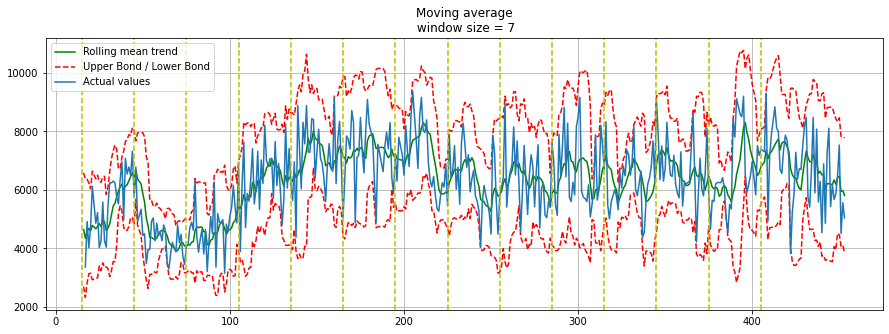

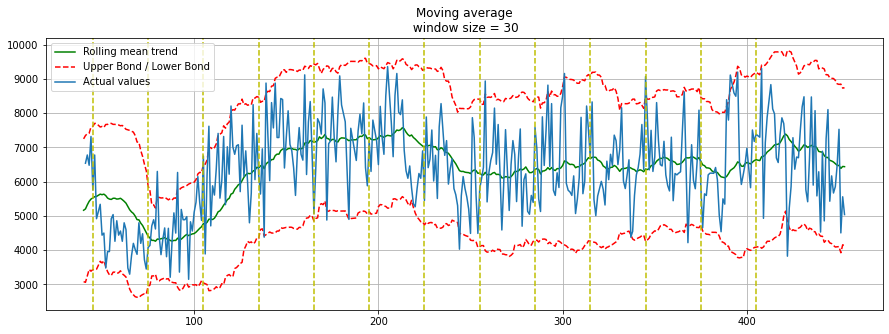

In [149]:
plotMovingAverage(dff, 7) # сглаживаем по неделям
x = 15
while x < len(df):
    plt.axvline(x, c='y', ls='--')
    x = x + 30
plotMovingAverage(dff, 30) # сглаживаем по месецам
x = 45
while x < len(df):
    plt.axvline(x, c='y', ls='--')
    x = x + 30



Конец просмотра

_________________________________________________________________

In [9]:
target = df['Выручка']

In [10]:
df = df.drop(columns='Выручка')

In [11]:
df['Температура'].describe()

count    432.000000
mean      10.898380
std       10.821842
min      -17.400000
25%        2.000000
50%       11.150000
75%       19.300000
max       33.600000
Name: Температура, dtype: float64

Поделим на категории во избежание переобучения

In [12]:
bins = [-50, 0, 15, 25, 50]
labels = [1, 2, 3, 4]
df['Температура'] = pd.cut(df['Температура'], bins=bins, labels=labels)

In [13]:
df['Температура']

0      2
1      2
12     3
13     3
14     3
      ..
449    3
450    3
451    3
452    2
453    3
Name: Температура, Length: 432, dtype: category
Categories (4, int64): [1 < 2 < 3 < 4]

Моделька

In [155]:
#cbr = CatBoostRegressor(iterations=1000, random_seed=rs, loss_function='RMSE')
#выдавал ~те же результаты что и catboost, потому не увидел в нем смысла

*

In [14]:
X_train, X_test, y_train, y_test = train_test_split(df, target, train_size=0.75, test_size=0.25, random_state=rs)

In [15]:
df.columns

Index(['Девочка', 'Мальчик', 'Месяц', 'Температура', 'Дождь', 'День недели'], dtype='object')

gs Сatboost

In [16]:
cat_features = ['Месяц', 'Температура', 'Дождь', 'День недели']

In [17]:
pool = Pool(X_train, y_train, cat_features=cat_features, feature_names=list(X_train.columns))

In [60]:
#grid = {'learning_rate': [0.03, 0.05, 0.1],
#        'depth': [2, 4, 6, 10],
#        'l2_leaf_reg': [1, 3, 5, 7, 9]} чем глубже, тем сильнее переобучение, тем хуже тест

grid = {'iterations': [500, 1000, 2500],
        'learning_rate': [0.03, 0.05],
        'depth': [2, 3, 4],
        'l2_leaf_reg': [1, 2, 3],
        'random_state':[rs],
        'metric_period':[250],
        'logging_level':['Silent']}

In [ ]:
gscb = CatBoost()
gsresult = gscb.grid_search(grid, X=pool, plot=True)

In [62]:
params = gsresult['params'] 

In [18]:
#params = {'learning_rate':0.05, 'depth':3, 'l2_leaf_reg':1, 'random_state':rs, 'metric_period':200, 'iterations':1000}
cbm = CatBoost(params=params)
cbm.fit(pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1377.0030380	total: 166ms	remaining: 2m 46s
200:	learn: 1076.8014728	total: 3.92s	remaining: 15.6s
400:	learn: 993.7463182	total: 7.13s	remaining: 10.6s
600:	learn: 929.7471405	total: 10.3s	remaining: 6.85s
800:	learn: 870.4568024	total: 13.6s	remaining: 3.38s
999:	learn: 819.2639918	total: 17.1s	remaining: 0us


In [19]:
tree_perfomance = []

In [20]:
for step in reversed(range(1, 1001, 1)):
    cbm.shrink(step)
    tree_perfomance.append([step, mean_squared_error(y_test, cbm.predict(X_test))])
    

In [21]:
length, rmse = min(tree_perfomance, key=lambda x: x[1])

In [22]:
length, rmse

(39, 1204832.302037558)

In [23]:
params = {'learning_rate':0.05, 'depth':3, 'l2_leaf_reg':1, 'random_state':rs, 'metric_period':200, 'iterations':1000}
cbm = CatBoost(params=params)
cbm.fit(pool, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 1377.0030380	total: 87.3ms	remaining: 1m 27s
200:	learn: 1076.8014728	total: 3.32s	remaining: 13.2s
400:	learn: 993.7463182	total: 6.52s	remaining: 9.74s
600:	learn: 929.7471405	total: 9.63s	remaining: 6.39s
800:	learn: 870.4568024	total: 12.8s	remaining: 3.19s
999:	learn: 819.2639918	total: 15.9s	remaining: 0us


In [24]:
cbm.shrink(39)

In [25]:
mean_squared_error(y_test, cbm.predict(X_test)) #обучена в 1000 итераций и обрезана до 39

1204832.302037558

In [154]:
mean_squared_error(y_test, cbm.predict(X_test)) #обучена в 100 итераций и обрезана до 39

1247774.3492777476

In [125]:
mean_squared_error(y_test, cbm.predict(X_test)) #обучена в 39 итераций

1247774.3492777476

Если обучать модель с 39 итерациями - получается другой результат, хуже <br/>
Преполагаю, что при shirnk() убираются наименее важные деления, и в итоге повторно выбираются лучшие деления <br/>
Разница 3.5% по метрике RMSE

В идеале можно изучить деление деревьев до и после, но я не разберусь в происходящем

In [164]:
1247774.349/1204832.302

1.0356415137017134

____________________________________________________________________

cbm не умеет в grid лосс функций (или я не разобрался с встроенным гридом)

Тест лоссфункций простым перебором вручную, уже известно что лучшими показателями на отложенной выборке оказались lr=0.05, d=3, l2lr=1

Метрика при обучении / результат в rmse <br/>
RMSE 1243385.82 46 iter <br/>
RMSE 1404311.77 1k iter<br/>
RMSE 1694170.17 5k iter <br/>
RMSE 1536752.13 2k iter <br/>
RMSE 1541271.88 без столбца температура <br/>
MAE 1471720.65 <br/>
MAPE 1414749.41 <br/>
Quantile 1471720.65 <br/>
Huber 15155710.68 0.2 <br/>
Huber  5083909.92 0.5 <br/>
Huber  2377977.18 0.8 <br/>
Huber  1997919.79 0.9 <br/>
Huber  1888333.05 0.95<br/>
Huber  1403189.48 1.5 <br/>
Huber  1312537.61 3.0 <br/>
Huber  1309875.98 3.5 0.7/0.3 <br/>
Huber  1458538.07 3.5 0.75/0.25 <br/>
Huber  1402136.98 3.5 0.75/0.25 без столбца "температура"<br/>
Тут уже быстро выходит на асимптоту и не обучается толком дальше

____________________________________________________

In [42]:
target.describe()

count     432.000000
mean     6277.430556
std      1346.993256
min      3150.000000
25%      5398.750000
50%      6250.000000
75%      7290.000000
max      9360.000000
Name: Выручка, dtype: float64

In [49]:
y_test.describe()

count     108.000000
mean     6269.675926
std      1215.510599
min      3150.000000
25%      5517.500000
50%      6205.000000
75%      7200.000000
max      9305.000000
Name: Выручка, dtype: float64

In [120]:
diff = cbm.predict(X_test) - y_test
diff = pd.DataFrame(diff)
diff.describe()

,Выручка
count,108.000000
mean,22.651104
std,1102.530974
min,-2828.462942
25%,-688.401771
50%,119.496614
75%,813.620577
max,2766.592272


Получается, что Модель в среднием ошибается меньше, чем стандартное отклонение, и чему-то она все-таки научилась)

____________________________________________________
Ohe+le предобработка для других моделей

In [26]:
le = LabelEncoder()

In [27]:
dfn = df.copy()

In [28]:
dfn['День недели'] = le.fit_transform(dfn['День недели'])

In [29]:
ohe = OneHotEncoder()

In [30]:
dfn = dfn.astype(int)

In [31]:
oheded = ohe.fit_transform(dfn)

In [32]:
X_train1, X_test1, y_train, y_test = train_test_split(oheded, target, train_size=0.75, test_size=0.25, random_state=rs)

__________________________________________________________________________

Random Forest Regressor выдает результаты хуже

In [32]:
rf = RandomForestRegressor()

In [33]:
#define your own mse and set greater_is_better=False
mse = make_scorer(mean_squared_error,greater_is_better=False)

In [256]:
gs = GridSearchCV(rf, scoring=mse, cv=5, return_train_score=True, param_grid={
    'max_depth': [7], #[3,4, 5, 6, 7, 8, 9, 10, None],
    'max_features': ['log2'], #['auto', 'log2', None],
    'min_samples_leaf': [2], #range(1, 10),
    'min_samples_split':[6], # range(2, 10),
    'random_state': [rs],
    'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100, 150, 200, 250, 300]
})

In [257]:
gs.fit(X_train1, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [7], 'max_features': ['log2'],
                         'min_samples_leaf': [2], 'min_samples_split': [6],
                         'n_estimators': [30, 40, 50, 60, 70, 80, 90, 100, 150,
                                          200, 250, 300],
                         'random_state': [1385]},
             return_train_score=True,
             scoring=make_scorer(mean_squared_error, greater_is_better=False))

In [258]:
gs.best_params_

{'max_depth': 7,
 'max_features': 'log2',
 'min_samples_leaf': 2,
 'min_samples_split': 6,
 'n_estimators': 90,
 'random_state': 1385}

In [34]:
rfr = RandomForestRegressor(n_estimators=90, max_depth=7, max_leaf_nodes=5, min_samples_split=6, min_samples_leaf=2, max_features='log2', random_state=rs)

In [35]:
rfr.fit(X_train1, y_train)

RandomForestRegressor(max_depth=7, max_features='log2', max_leaf_nodes=5,
                      min_samples_leaf=2, min_samples_split=6, n_estimators=90,
                      random_state=1385)

In [36]:
mean_squared_error(y_test, rfr.predict(X_test1))

1270553.1888217423

In [33]:
X_lgbm = X_train.copy()

In [34]:
X_lgbm_test = X_test.copy()

In [35]:
for col in X_lgbm.select_dtypes(include=['int64', 'object']):
    X_lgbm[col] = X_lgbm[col].astype('category')

for col in X_lgbm_test.select_dtypes(include=['int64', 'object']):
    X_lgbm_test[col] = X_lgbm_test[col].astype('category')


In [36]:
X_lgbm.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 53 to 389
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   Девочка      324 non-null    category
 1   Мальчик      324 non-null    category
 2   Месяц        324 non-null    category
 3   Температура  324 non-null    category
 4   Дождь        324 non-null    category
 5   День недели  324 non-null    category
dtypes: category(6)
memory usage: 5.7 KB


In [37]:
lgbm = LGBMRegressor()

In [175]:
lgbm_grid = {
    'max_depth': [2, 3, 5, 6],
    'num_leaves': [2, 3, 4, 5, 6, 8],
    'learning_rate':[0.01, 0.05, 0.1, 0.25],
    'reg_lambda': [0.05, 0.1, 0.25],
    'n_estimators':[20, 25, 30, 35],
    'min_child_samples':[5, 10, 20, 30],
    'random_state':[rs],
    'n_jobs':[4]
    }

In [176]:
gsearch = GridSearchCV(estimator=lgbm, param_grid=lgbm_grid)

In [177]:
gsearch.fit(X_train1, y_train)

GridSearchCV(estimator=LGBMRegressor(),
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.25],
                         'max_depth': [2, 3, 5, 6],
                         'min_child_samples': [5, 10, 20, 30],
                         'n_estimators': [20, 25, 30, 35], 'n_jobs': [4],
                         'num_leaves': [2, 3, 4, 5, 6, 8],
                         'random_state': [1385],
                         'reg_lambda': [0.05, 0.1, 0.25]})

In [179]:
gsearch.best_params_

{'learning_rate': 0.1,
 'max_depth': 2,
 'min_child_samples': 5,
 'n_estimators': 30,
 'n_jobs': 4,
 'num_leaves': 4,
 'random_state': 1385,
 'reg_lambda': 0.1}

In [38]:
lgbmr = LGBMRegressor(boosting_type='gbdt',
    learning_rate=0.1,
    max_depth=2,
    min_child_samples=5,
    n_estimators=30,
    num_leaves=4,
    reg_lambda=0.1,
    objective='RMSE',
    n_jobs=4, 
    random_state=rs)

lgbmr.fit(X_lgbm, y_train)
y_pred = lgbmr.predict(X_lgbm_test)


lgbm_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("RMSE", np.mean(lgbm_rmse))

RMSE 1115.5132641081225


In [39]:
cbm_rmse = np.sqrt(mean_squared_error(y_test, cbm.predict(X_test)))
print("RMSE", np.mean(cbm_rmse))

RMSE 1097.6485330184512


_________________________________________________________________

Разница предикта и истинных значений

In [45]:
from sklearn.neighbors import KNeighborsRegressor
knr = KNeighborsRegressor(n_neighbors=10, weights='uniform', algorithm='auto', n_jobs=4)
#algorithm{‘auto’, ‘ball_tree’, ‘kd_tree’, ‘brute’}
#weights{‘uniform’, ‘distance’} 
#p1/2 манх/эквлид дист


In [46]:
knr.fit(X_train1, y_train)

KNeighborsRegressor(n_jobs=4, n_neighbors=10)

In [47]:
mean_squared_error(y_test, knr.predict(X_test1))

1316201.349537037

_________________________________________________________________

Блендинг трех моделей

In [65]:
def select_weights(y_true, y_pred_1, y_pred_2, y_pred_3):
    metric = []
    grid = np.linspace(0, 1, 1000)
    for w_2 in grid:
      for w_0 in grid:
        w_1 = 1 - w_0
        y = y_pred_1 * w_0 + y_pred_2 * w_1 + y_pred_3 * w_2

        metric.append([mean_squared_error(y_true, y), w_0, w_1, w_2])

    return metric 

In [87]:
rmse_blending_test, w_0, w_1, w_2 = min(select_weights(y_test, knr.predict(X_test1), cbm.predict(X_test), lgbmr.predict(X_lgbm_test)), key=lambda x: x[0])

In [92]:
rmse_blending_test 

1196258.9551755053

In [156]:
w_0, w_1, w_2 #попробовал обучить на ответах дерево и линейку, но результат получился хуже и в треине, и в тесте

(0.2182182182182182, 0.7817817817817818, 0.002002002002002002)

In [148]:
mean_squared_error(y_test, knr.predict(X_test1)*w_0+cbm.predict(X_test)*w_1+lgbmr.predict(X_lgbm_test)*w_2)

1196258.9551755053

__________________________________________

Обучение случайного леса на предсказаниях других моделей

In [322]:
x1 = knr.predict(X_train1)
x2 = cbm.predict(X_train)
x3 = lgbmr.predict(X_lgbm)

In [323]:
Xlr = pd.DataFrame(x1)
Xlr['x2'] = x2
Xlr['x3'] = x3
Xlr = Xlr.rename(columns={0:'x1'}, errors='raise')

In [324]:
Xlrt = pd.DataFrame(knr.predict(X_test1))
Xlrt['x2'] = cbm.predict(X_test)
Xlrt['x3'] = lgbmr.predict(X_lgbm_test)
Xlrt = Xlrt.rename(columns={0:'x1'})

In [330]:
rfrblend = RandomForestRegressor(n_estimators=2, max_depth=3, random_state=rs)
rfrblend.fit(Xlr, y_train)

RandomForestRegressor(max_depth=3, n_estimators=2, random_state=1385)

In [331]:
mean_squared_error(y_test, rfrblend.predict(Xlrt))

1120692.8772326047

In [346]:
rfrblend.feature_importances_

array([0.35812159, 0.47078777, 0.17109064])

__________________________

In [157]:
blendingres = knr.predict(X_test1)*w_0+cbm.predict(X_test)*w_1+lgbmr.predict(X_lgbm_test)*w_2 - y_test

In [332]:
rfrblended = rfrblend.predict(Xlrt) - y_test

In [336]:
y_test.describe() #распределение в тестовых данных

count     108.000000
mean     6269.675926
std      1215.510599
min      3150.000000
25%      5517.500000
50%      6205.000000
75%      7200.000000
max      9305.000000
Name: Выручка, dtype: float64

In [401]:
blendres = knr.predict(X_test1)*w_0+cbm.predict(X_test)*w_1+lgbmr.predict(X_lgbm_test)*w_2
blendres = pd.DataFrame(blendres)
blendres.describe()

,0
count,108.000000
mean,6274.041293
std,485.242238
min,4851.626838
25%,6000.982164
50%,6418.070392
75%,6574.369757
max,7060.471197


In [402]:
rfrres = rfrblend.predict(Xlrt)
rfrres = pd.DataFrame(rfrres)
rfrres.describe()

,0
count,108.000000
mean,6212.224827
std,821.219328
min,3733.125000
25%,5711.543706
50%,6183.919499
75%,6693.750570
max,7885.953782


Больше нравятся результаты, которые выдает, обученный на предсказаниях, случайный лес

____________________________________________________________________________________

In [ ]:
x1 = knr.predict(X_train1)
x2 = cbm.predict(X_train)
x3 = lgbmr.predict(X_lgbm)

rfrblend.predict()

In [390]:
x8 = 5600
x9 = 7800
x7 = 6200
d = {'x1': [x8], 'x2': [x9], 'x3': [x7]}
pred = pd.DataFrame(data=d)

In [ ]:
def predictpls(day_variables):

    ..................
    x1 = knr.predict(dv)
    x2 = cbm.predict(dv)
    x3 = lgbmr.predict(dv)
    data = {'x1':[x1], 'x2':[x2], 'x3':[x3]}
    pred = pd.DataFrame(data=data)

_________________________________________________________________________

Одна из проблем деревьев - они не могут предсказывать значения выше/ниже ранее виденных
Т.е. дерево не сможет предсказать значение выручки выше 9500

Изначально мне было интереснее всего то, кто из бариста вносит больший вклад <br/>
Из весов стали очевидны два вывода:

1. Бариста девочка имеет больший вес <br/>
2. Бариста в принципе имеют минимальный вес, а выручка носит сезонный характер

_______________________________________________________________________________

Добавить колонку с средним за последние 3/5/7 дней

Написать отдельный файл с сохраненными моделями

Сделать функцию, в которую можно помещать сегодняшние переменные,  чтобы одна модель выдавала предсказание